In [1]:
"""
Two-Body System Analysis
Investigating the central mass in Omega Centauri
Modelling of individual stellar orbits with distributions of orbital parameters
See Also: Octofitter
https://github.com/sefffal/octofitterpy
"""

'\nTwo-Body System Analysis\nInvestigating the central mass in Omega Centauri\n'

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import pyasl
import two_body_utils as utils
import astropy.units as u
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime


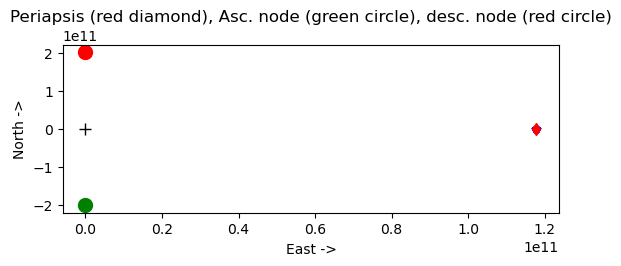

In [3]:
"""
#Single Orbital Plot
"""

# Get a sample period in seconds
per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

#Calculate a single orbit -- No units in arguments
kes = pyasl.KeplerEllipse(a = utils.semi_major_sample.value, per= per_sample.value, e = utils.e[0], Omega= utils.Omega, 
                             i= utils.i, w=utils.w)

# Get a time axis
# No units in arguments
# np.linspace(start,stop,num)
t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# Calculate the orbit position at the given points in a Cartesian coordinate system.
pos = kes.xyzPos(t)

# Calculate the orbit radius 
radius = kes.radius(t)

# Calculate velocity on orbit
vel = kes.xyzVel(t)

# Find the nodes of the orbit (Observer at -z)
ascn, descn = kes.xyzNodes_LOSZ()
# Plot x and y coordinates of the orbit
plt.subplot(2, 1, 1)
plt.title("Periapsis (red diamond), Asc. node (green circle), desc. node (red circle)")
plt.xlabel("East ->")
plt.ylabel("North ->")
plt.plot([0], [0], 'k+', markersize=9)
plt.plot(pos[::, 1], pos[::, 0], 'bp')
# Point of periapsis
plt.plot([pos[0, 1]], [pos[0, 0]], 'rd')
# Nodes of the orbit
plt.plot([ascn[1]], [ascn[0]], 'go', markersize=10)
plt.plot([descn[1]], [descn[0]], 'ro', markersize=10)

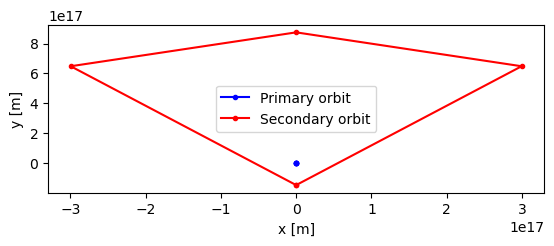

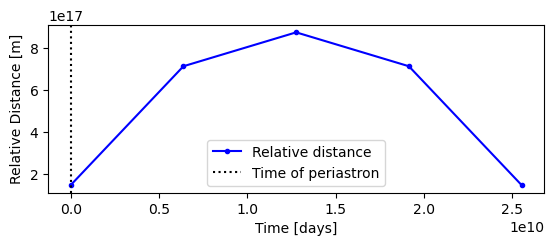

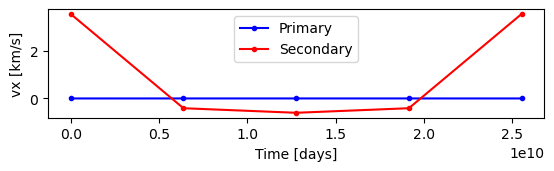

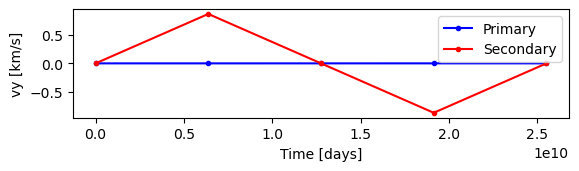

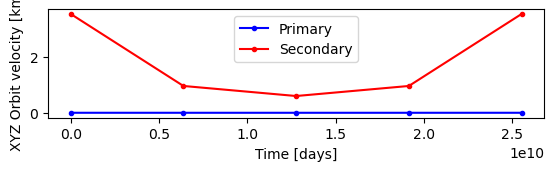

In [7]:

"""
#Single Binary Orbit Plots
"""


# Get a sample period in seconds
per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# Calculate a single binary orbit
# no units in arguments 
bo = pyasl.BinaryOrbit(utils.m2m1, utils.mtot, per_sample.value, utils.e[0], 
                       utils.tau, utils.Omega, utils.w, utils.i)

# Get a time axis
# No units in arguments!
# np.linspace(start,stop,num)
t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# Calculate primary and secondary orbit
ke1 = bo.getKeplerEllipse_primary()
ke2 = bo.getKeplerEllipse_secondary()

# velocities and radii of single orbit
r1s, r2s = bo.xyzPos(t)
v1s, v2s = bo.xyzVel(t)

# Relative distance of masses (centers) of single orbit
rds = np.sqrt(np.sum((r1s-r2s)**2, axis=1))

#Plot binary orbit
plt.subplot(2,1,1)
plt.plot(r1s[::,0], r1s[::,1], 'b.-', label="Primary orbit")
plt.plot(r2s[::,0], r2s[::,1], 'r.-', label="Secondary orbit")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.show()
print()
print()

#Plot relative distances
plt.subplot(2,1,2)
plt.plot(t/86400, rds, 'b.-', label="Relative distance")
plt.axvline(utils.tau, ls=':', c='k', label="Time of periastron")
plt.xlabel("Time [days]")
plt.ylabel("Relative Distance [m]")
plt.legend()
plt.show()
print()
print()

# plot x-velocity
plt.subplot(3,1,1)
plt.plot(t/86400, v1s[::,0]/1e3, 'b.-', label="Primary")
plt.plot(t/86400, v2s[::,0]/1e3, 'r.-', label="Secondary")
plt.xlabel("Time [days]")
plt.ylabel("vx [km/s]")
plt.legend()
plt.show()
print()

# plot y-velocity
plt.subplot(3,1,2)
plt.plot(t/86400, v1s[::,1]/1e3, 'b.-', label="Primary")
plt.plot(t/86400, v2s[::,1]/1e3, 'r.-', label="Secondary")
plt.xlabel("Time [days]")
plt.ylabel("vy [km/s]")
plt.legend()
plt.show()
print()

# plot orbit velocities
plt.subplot(3,1,3)
ov1s = np.sqrt(np.sum(v1s**2, axis=1))
ov2s = np.sqrt(np.sum(v2s**2, axis=1))
plt.plot(t/86400, ov1s/1e3, 'b.-', label="Primary")
plt.plot(t/86400, ov2s/1e3, 'r.-', label="Secondary")
plt.xlabel("Time [days]")
plt.ylabel("XYZ Orbit velocity [km/s]")
plt.legend()
plt.show()


In [9]:
# """
# Binary System Calculations with KeplerEllipse 
# """
# eccentricities 
# 100 random eccentricities from the thermal distribution 
# The CDF (F(e)) gives probability
# The inverse CDF turns uniform random samples into samples that match probability density
# f(e) = 2e, so more eccentric orbits are more likely than circular
# u=F(e)=e, each proability value is equally likely and maps to some value of e 
p = np.random.uniform(0, 1, utils.n_int)
ecc_distribution_ke = np.sqrt(p)

#Solver for Kepler's equation
# Solves Kepler's Equation for a set
# of mean anomaly and eccentricity.
ks = pyasl.MarkleyKESolver()
print("Eccentric anomalies: \n",ks.getE(utils.M, ecc_distribution_ke))

# # Get a sample period in seconds
per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# Get a time axis of units based on input
# No units in arguments
# np.linspace(start,stop,num)
t = np.linspace(utils.tau, per_sample.value, utils.n_int)

# Initialize empty arrays 
positions = np.zeros((len(ecc_distribution_ke), len(t), 3))  
velocities = np.zeros_like(positions)
radii = np.zeros((len(ecc_distribution_ke), len(t)))

# Loop over each eccentricity and timestep and calculate position, velocity, radius
for k, e_val in enumerate(ecc_distribution_ke):
     # Calculate the ellipse for each value of eccentricity --- No units in arguments! -- output units depend on input
      ke = pyasl.KeplerEllipse(a = utils.semi_major_sample.value, per = per_sample.value, e = e_val, Omega= utils.Omega, 
                               i= utils.i, w=utils.w)

      for j, time in enumerate(t):
          positions[k, j] = ke.xyzPos(time)
          velocities[k, j] = ke.xyzVel(time)
          radii[k, j] = ke.radius(time)

# Get magnitudes of xyz velocities
velocities_magnitudes = np.linalg.norm(velocities[:,:, :2], axis=2) 

# Print results
print("\nShape of output array: ", positions.shape, "\n")
print("Units of output correspond to input:",utils.semi_major_sample.unit,"and", per_sample.unit, "\n")
print("x, y, z velocities for the", utils.n_int, "timesteps and eccentricites: \n", velocities[:,:, :: ])
print("\n\nCorresponding Magnitudes:\n", velocities_magnitudes)

Eccentric anomalies: 
 [1.36002432 1.4871255  1.45353287 0.98158796 1.32882147]

Shape of output array:  (5, 5, 3) 

Units of output correspond to input: km and s 

x, y, z velocities for the 5 timesteps and eccentricites: 
 [[[-2.07767737e+02  1.27221047e-14  0.00000000e+00]
  [ 3.02805219e+01 -6.51858591e+01 -0.00000000e+00]
  [ 4.81306682e+01 -1.04888721e-14 -0.00000000e+00]
  [ 3.02805219e+01  6.51858591e+01  0.00000000e+00]
  [-2.07767737e+02  1.27221047e-14  0.00000000e+00]]

 [[-2.58531126e+02  1.58304658e-14  0.00000000e+00]
  [ 2.70050953e+01 -5.77375605e+01 -0.00000000e+00]
  [ 3.86800620e+01 -9.40783064e-15 -0.00000000e+00]
  [ 2.70050953e+01  5.77375605e+01  0.00000000e+00]
  [-2.58531126e+02  1.58304658e-14  0.00000000e+00]]

 [[-2.42046656e+02  1.48210831e-14  0.00000000e+00]
  [ 2.81377406e+01 -5.96666907e+01 -0.00000000e+00]
  [ 4.13143490e+01 -9.69816803e-15 -0.00000000e+00]
  [ 2.81377406e+01  5.96666907e+01  0.00000000e+00]
  [-2.42046656e+02  1.48210831e-14  0.00000